# Points d'arrêt

## Contexte

On a pu mettre en pratique différents [points d'arrêt](https://docs.langchain.com/oss/python/langgraph/interrupts#debugging-with-interrupts) (statiques, dynamiques, HITL) dans les modules précédents. Rentrons davantage dans les détails.

## Objectifs

Implémenter un HITL peut répondre à plusieurs besoins:

1. `Approbation`: interrompre notre agent, exposer l'état à un utilisateur et permettre à celui-ci d'approuver une action

2. `Débogage`: rembobiner le graphe pour reproduire ou éviter des problèmes

3. `Édition`: modifier l'état

Implémentons l'`approbation` par l'utilisateur.

In [12]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Points d'arrêt pour l'approbation humaine (HITL)

Reprenons l'exemple du module 1.

Supposons que nous soyons préoccupés par l'utilisation des outils: on souhaite approuver l'utilisation de n'importe lequel des outils par l'agent.

Il suffit de compiler le graphe avec `interrupt_before=["tools"]` où `tools` est notre noeud d'outils.

Cela signifie que l'exécution sera interrompue avant le noeud `tools`, qui exécute l'appel d'outil.

In [14]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiplie a et b.

    Args:
        a: entier
        b: entier
    """
    return a * b

# outil
def add(a: int, b: int) -> int:
    """Additionne a et b.

    Args:
        a: entier
        b: entier
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divise a par b.

    Args:
        a: entier
        b: entier
    """
    if b == 0:
        raise ValueError("Division par zéro non autorisée.")

    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

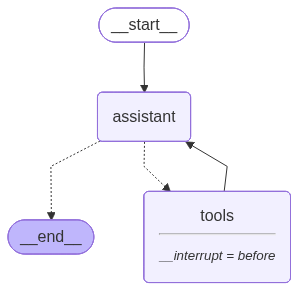

In [15]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# instruction système
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# noeud
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"]) ]}

# graphe
builder = StateGraph(MessagesState)

# définition des noeuds (ce qui fait le travail)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# définition des arêtes (qui contrôle le parcours)
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # si le dernier message (résultat) de l'assistant est un appel d'outil: tools_condition dirige vers tools
    # sinon: tools_condition dirige vers END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# représentation
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [16]:
# entrée
initial_input = {"messages": HumanMessage(content="Multiplie 8 par 12.")}

# fil d'exécution
thread = {"configurable": {"thread_id": "1"}}

# exécution du graphe jusqu'au premier point d'arrêt
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiplie 8 par 12.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_w2e0FDn4ssy5cB6L9T6TIYMm)
 Call ID: call_w2e0FDn4ssy5cB6L9T6TIYMm
  Args:
    a: 8
    b: 12


Nous pouvons obtenir l'état et regarder le prochain noeud à appeler pour vérifier que le graphe a bien été interrompu.

In [17]:
state = graph.get_state(thread)
state.next

('tools',)

Lorsque nous invoquons le graphe avec `None`, il continue simplement à partir du dernier point de contrôle d'état.

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

Le processus reprendra simplement l'état courant (qui contient le `AIMessage` avec l'appel d'outil) et continuera à partir de là.
Puis il exécutera les étapes suivantes du graphe, qui commencent par le noeud d'outils.

On voit que le noeud d'outils est exécuté avec cet appel, et le résultat est renvoyé au modèle de chat pour obtenir la réponse finale.

In [18]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_w2e0FDn4ssy5cB6L9T6TIYMm)
 Call ID: call_w2e0FDn4ssy5cB6L9T6TIYMm
  Args:
    a: 8
    b: 12
================================= Tool Message =================================
Name: multiply

96
================================== Ai Message ==================================

8 multiplié par 12 donne 96.


Maintenant, rassemblons le tout avec une étape spécifique d'approbation utilisateur qui demande une saisie.

In [20]:
# entrée
initial_input = {"messages": HumanMessage(content="Multiplie 8 par 12.")}

# fil d'exécution
thread = {"configurable": {"thread_id": "2"}}

# exécute le graphe jusqu'au premier point d'arrêt
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# récupère l'approbation de l'utilisateur avant d'appeler l'outil
user_approval = input("Voulez-vous utiliser l'outil? (y/N): ")

# vérifie la réponse
if user_approval.lower() == "y":
    
    # si approuvé, continue l'exécution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Opération annulée par l'utilisateur.")

================================ Human Message =================================

Multiplie 8 par 12.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Ry8tWzjWqXtEcOjYcPbPemYj)
 Call ID: call_Ry8tWzjWqXtEcOjYcPbPemYj
  Args:
    a: 8
    b: 12
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Ry8tWzjWqXtEcOjYcPbPemYj)
 Call ID: call_Ry8tWzjWqXtEcOjYcPbPemYj
  Args:
    a: 8
    b: 12
================================= Tool Message =================================
Name: multiply

96
================================== Ai Message ==================================

Le produit de 8 multiplié par 12 est 96.
